In [1]:
import numpy as np
from scipy import stats
import scipy.io as sp
import metpy
import metpy.calc as mpcalc
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from cmcrameri import cm
from scipy import optimize
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
def log_r2(modelled_weathering, obs_weathering):

    RSS = sum((np.log(modelled_weathering) - np.log(obs_weathering))**2)
    TSS = sum((np.log(obs_weathering) - np.mean(np.log(obs_weathering)))**2)
    
    r2 = 1 - RSS/TSS
    
    return(r2)

In [6]:
def get_basin_weathering(variables, constants):
    '''
    constants are:
    1/ suture map
    2/ tslope map
    3/ T map
    4/ Q map
    5/ polygon area of river basins
    '''
    SUTURE = constants[0]
    tslope = constants[1]
    T = constants[2]
    Q = constants[3]
    polygon_area = constants[4]
    ARC = constants[5]
    RELICT = constants[6]
    
    ##### pierre erosion calculation
    k_erosion = 6.5e-4 #### use normal value
    #### Pierre params
    Xm = 0.1 #cation abundance in source rock
    Ea = 20 #apparent activation energy
    z = 10 #regolith (kg/m2)
    #callibration constants
    K = variables[0]#6e-5
    kw = variables[1]#1e-3
    sigplus1 = variables[2]*1000#0.9
    arc_factor = variables[3]*1000000#700
    suture_factor = variables[4]*1000000#700
    relict_factor = arc_factor
    print(K, kw, sigplus1, arc_factor, suture_factor)
    ##### fixed params
    T0 = 286 #standard temp in K
    R = 8.31e-3 #ideal gas constant

    TC = T - 273
    epsilon = k_erosion * (Q**0.31) * tslope * np.maximum(TC, 2)

    #### T, Q and erosion dependencies (but don't matter since we're taking directly from model results)
    R_T = np.exp( ( Ea / (R*T0) ) - ( Ea / (R*T) ) )
    R_Q = 1 - np.exp( -1 * kw * Q )
    R_reg = ( (z/epsilon)**sigplus1) / sigplus1

    #mask out some areas
    arc_mask = ARC != 0
    suture_mask = SUTURE != 0
    relict_mask = RELICT != 0

    
    #### West (2012) combined dependency model, *1e6 to get to t/km2/yr
    CW_raw = epsilon * Xm * ( 1 - np.exp( -1* K * R_Q * R_T * R_reg ) ) * 1e6
    CW_raw_AF = CW_raw *( 1 + ARC * ( arc_factor - 1 ) ) * arc_mask
    CW_raw_SF = CW_raw *( 1 + SUTURE * ( suture_factor - 1 ) ) * suture_mask
    CW_raw_RAF = CW_raw *( 1 + RELICT * ( relict_factor - 1 ) ) * relict_mask
    non_arc_suture_weathering_present = CW_raw * (arc_mask != True) * (suture_mask != True) * (relict_mask != True)
    CW = CW_raw_AF + CW_raw_SF + CW_raw_RAF + non_arc_suture_weathering_present
    
    bulkbasinweathering = sum_basin_weathering_FOAM(polygon_area, CW)
    
    return bulkbasinweathering, CW_raw_AF, CW_raw_SF, CW_raw_RAF, CW

In [7]:
def sum_basin_weathering_PD(polygon_area, CW):
    
    bulkbasinweathering = np.zeros([len(polygon_area),])
    for i in np.arange(len(polygon_area)):

        thisarea = np.flipud(polygon_area[i,:,:]/1000000)
        #check this line
        basinweathering = CW*thisarea.data
        #print(basinweathering)
        basinweathering[np.isnan(basinweathering)] = 0
        bulkbasinweathering[i] = np.nansum(np.nansum(basinweathering))

    return bulkbasinweathering

In [8]:
def sum_basin_weathering_FOAM(polygon_area, CW):
    bulkbasinweathering = np.zeros([len(polygon_area),])

    for i in np.arange(len(polygon_area)):

        thisarea = polygon_area[i,:,:]/1000000
        #check this line
        basinweathering = CW*np.roll(thisarea.data, 24, axis=1)
        #print(basinweathering)
        basinweathering[np.isnan(basinweathering)] = 0
        bulkbasinweathering[i] = np.nansum(np.nansum(basinweathering))

    return bulkbasinweathering

In [9]:
#load data

file_to_open_INTERPSTACK ='./forcings/INTERPSTACK_sep2021_v4.mat'
mat_contents = sp.loadmat(file_to_open_INTERPSTACK)

#river data SCION
river_poly_file_FOAM = './Maffre_equations/all_basin_FOAM-48x40.nc'
river_poly_FOAM = xr.open_dataset(river_poly_file_FOAM)
polygon_area_FOAM = river_poly_FOAM['polygon_area']

#river data PD
river_poly_file_PD = './Maffre_equations/all_basin_0.5deg.nc'
river_poly_PD = xr.open_dataset(river_poly_file_PD)
polygon_area_PD = river_poly_PD['polygon_area']

#for evaluation
WorldRivers_file = './Maffre_equations/WorldRivers.mat'
WorldRivers = sp.loadmat(WorldRivers_file)
WorldRivers_array = (WorldRivers['WorldRivers'] * 1e6).reshape(len(WorldRivers['WorldRivers']),)

SCION results data

In [10]:
lat_FOAM = mat_contents['INTERPSTACK'][0][0][5][0]
lon_FOAM = mat_contents['INTERPSTACK'][0][0][6][0]
land_FOAM = mat_contents['INTERPSTACK'][0][0][4][:,:,21] #present day land
sutures_FOAM = mat_contents['INTERPSTACK'][0][0][10][:,:,21] #present day sutures
arcs_FOAM = mat_contents['INTERPSTACK'][0][0][14][:,:,21]*2 #present day arcs
relict_arcs_FOAM = mat_contents['INTERPSTACK'][0][0][13][:,:,21]

relict_arcs_FOAM = relict_arcs_FOAM*(arcs_FOAM == 0).astype(int)
relict_arcs_FOAM = np.minimum(1, (relict_arcs_FOAM * 2))

#### weathering calculation fields
T_FOAM = mat_contents['INTERPSTACK'][0][0][2][:,:,7,21] + 273 ### K
Q_FOAM = mat_contents['INTERPSTACK'][0][0][3][:,:,7,21] ### mm/yr
height_FOAM = mat_contents['INTERPSTACK'][0][0][7][:,:,21]  ### m
height_FOAM[np.isnan(height_FOAM)==1] = 0 

#### only have land
T_FOAM = T_FOAM * land_FOAM
Q_FOAM = Q_FOAM * land_FOAM
height_FOAM = height_FOAM * land_FOAM

#gradient of slope
y_lat_FOAM = np.asarray(lat_FOAM.reshape(40,))
x_lon_FOAM = np.asarray(lon_FOAM.reshape(48,))
#get meshgrid
d_lon_FOAM, d_lat_FOAM = metpy.calc.lat_lon_grid_deltas(np.asarray(x_lon_FOAM), np.asarray(y_lat_FOAM))
#calculate gradient
dFdyNorth_FOAM, dFdxEast_FOAM = mpcalc.gradient(height_FOAM, deltas=(d_lat_FOAM, d_lon_FOAM))
#calculate slope
tslope_FOAM = np.asarray(( dFdyNorth_FOAM**2 + dFdxEast_FOAM**2 )**0.5)



These two cells compute our 'real world' present day values

In [11]:
#load files for present_day
file_to_open_CRU_dataset ='./Maffre_equations/CRU_dataset.mat'
CRU_dataset = sp.loadmat(file_to_open_CRU_dataset)

lat = np.copy(CRU_dataset['lat'])
lon = np.copy(CRU_dataset['lon'])
pre_avg = np.copy(CRU_dataset['pre_avg'])
tmp_avg = np.copy(CRU_dataset['tmp_avg'])

file_to_open_NASA_data ='./Maffre_equations/NASA_topo.mat'
NASA_data = sp.loadmat(file_to_open_NASA_data)

NASA_lat = np.copy(NASA_data['NASA_lat'])
NASA_lon = np.copy(NASA_data['NASA_lon'])
NASA_topo = np.copy(NASA_data['NASA_topo'])

#### read regridded runoff from fekek eet al., 2002
file_to_open_fekeke_run_regrid ='./Maffre_equations/fekeke_run_regrid.mat'
fekeke_run_regrid = sp.loadmat(file_to_open_fekeke_run_regrid)

run_lat = np.copy(fekeke_run_regrid['run_lat'])
run_lon = np.copy(fekeke_run_regrid['run_lon'])
run_data = np.copy(fekeke_run_regrid['run_data'])

run_data[run_data < 0] = 0
run_data[np.isnan(run_data) == 1] = 0

#### find land
land = tmp_avg > -999
### remove water temps at -999
tmp_avg[tmp_avg < -100] = 15

### remove water
tmp_avg = tmp_avg*land 
tmp_avg[tmp_avg == 0] = np.nan
pre_avg[pre_avg < 0] = 0
##get oceans

#transpose and flip
tmp_avg = np.flipud(tmp_avg.T)
run_data = np.flipud(run_data)
#topo = np.copy(np.flipud(NASA_topo))
topo = NASA_topo
topo[topo==99999] = 0

In [12]:
################### HadCM3 present day ######################
############################################################


#### weathering calculation
T = tmp_avg + 273 ### K
# Q = pre_avg ### mm/yr
Q = run_data ### mm/yr
height = topo ### m

#gradient of slope
y_lat = np.asarray(lat.reshape(360,))
x_lon = np.asarray(lon.reshape(720,))
#get meshgrid
d_lon, d_lat = metpy.calc.lat_lon_grid_deltas(np.asarray(x_lon), np.asarray(y_lat))
#calculate gradient
dFdyNorth, dFdxEast = mpcalc.gradient(height, deltas=(d_lat, d_lon))
#calculate slope
tslope = np.asarray(( dFdyNorth**2 + dFdxEast**2 )**0.5)

##### pierre erosion calculation
k_erosion = 6.5e-4
TC = tmp_avg
epsilon = k_erosion * (Q**0.31) * tslope *  np.maximum(TC,2)

#### Pierre params
Xm = 0.1
K = 6e-5
kw = 1e-3
Ea = 20
z = 10
sigplus1 = 0.9

##### fixed params
T0 = 286
R = 8.31e-3

#suture
suture_factor = 1

##### T, Q and erosion dependencies
R_T = np.exp( ( Ea / (R*T0) ) - ( Ea / (R*T) ) )
R_Q = 1 - np.exp( -1*kw * Q )
R_reg = ( (z/epsilon)**sigplus1 ) / sigplus1

# West (2012) combined dependency model, *1e6 to get to t/km2/yr
CW = epsilon * Xm * ( 1 - np.exp( -1 * K * R_Q * R_T * R_reg ) ) * 1e6

present_day_fixed_variables = [K, kw, sigplus1, suture_factor]
bulkbasinweathering_PD = sum_basin_weathering_PD(polygon_area_PD, CW)

/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply


In [13]:
#default SCION run
default_variables = [6e-5, 1e-3, 0.9, 1/1000000, 1/1000000]
constants_data_FOAM = [sutures_FOAM, tslope_FOAM, T_FOAM, Q_FOAM, polygon_area_FOAM, arcs_FOAM, relict_arcs_FOAM]

bulkbasinweathering_FOAM = get_basin_weathering(default_variables, constants_data_FOAM)
#get weathering data
initial_variables = [6e-5, 1e-5, 0.9/1000, 1/1000000, 1/1000000]
weathering = get_basin_weathering(initial_variables, constants_data_FOAM)

6e-05 0.001 900.0 1.0 1.0
6e-05 1e-05 0.9 1.0 1.0


/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in power
/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


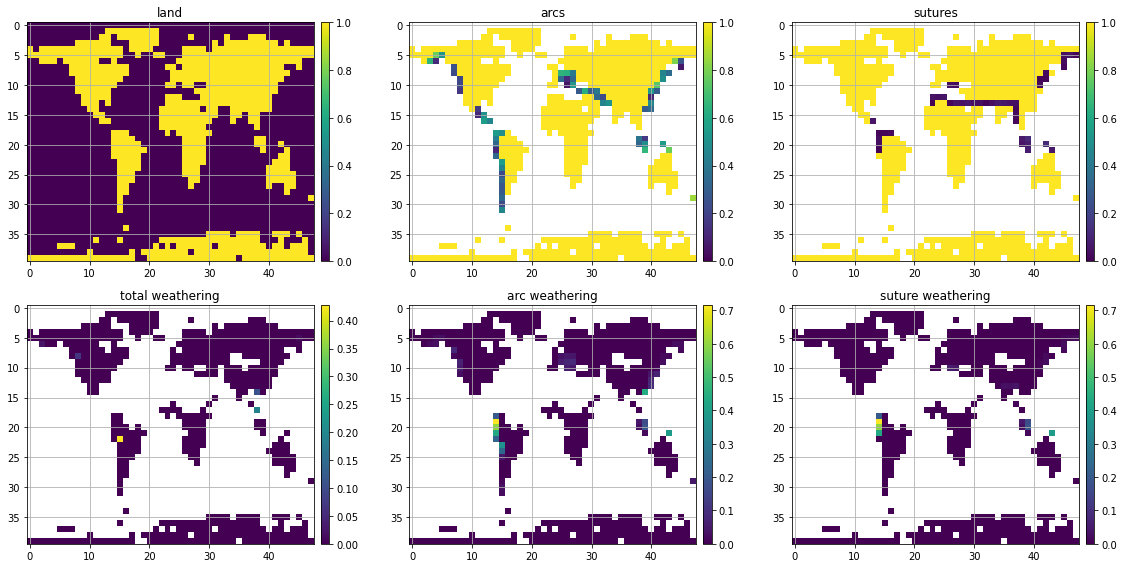

In [14]:
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(16,8))

tmp_sutures = np.where(sutures_FOAM!=0, sutures_FOAM, land_FOAM)
tmp_arcs = np.where(arcs_FOAM!=0, arcs_FOAM, land_FOAM)

tmp_sutures[tmp_sutures==0] = np.nan
tmp_arcs[tmp_arcs==0] = np.nan
    
im1 = ax1.imshow(land_FOAM)
ax1.set_title('land')
ax1.grid()
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='3%', pad=0.1)
fig.colorbar(im1, cax=cax1)#, fraction=0.038, pad=0.04)

im2 = ax2.imshow(tmp_arcs, vmin=0, vmax=1)
ax2.set_title('arcs')
ax2.grid()
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='3%', pad=0.1)
fig.colorbar(im2, cax=cax2)#, fraction=0.038, pad=0.04)


im3 = ax3.imshow(tmp_sutures, vmin=0, vmax=1)
ax3.set_title('sutures')
ax3.grid()
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('right', size='3%', pad=0.1)
fig.colorbar(im3, cax=cax3)#, fraction=0.038, pad=0.04)
#fig.suptitle('%s, %s Ma' % (ind, time), x=0.5, y=.62, fontsize=20)

#____

im4 = ax4.imshow(weathering[3])#, vmin=0, vmax=1)
ax4.set_title('total weathering')
ax4.grid()
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes('right', size='3%', pad=0.1)
fig.colorbar(im4, cax=cax4)#, fraction=0.038, pad=0.04)

im5 = ax5.imshow(weathering[1])
ax5.set_title('arc weathering')
ax5.grid()
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes('right', size='3%', pad=0.1)
fig.colorbar(im5, cax=cax5)#, fraction=0.038, pad=0.04)


im6 = ax6.imshow(weathering[2])
ax6.set_title('suture weathering')
ax6.grid()
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes('right', size='3%', pad=0.1)
fig.colorbar(im6, cax=cax6)#, fraction=0.038, pad=0.04)
#fig.suptitle('%s, %s Ma' % (ind, time), x=0.5, y=.62, fontsize=20)
fig.tight_layout()



In [15]:
ys = WorldRivers_array

def fun(variables):
    return get_basin_weathering(variables, constants_data_FOAM)[0]-ys

In [18]:

initial_variables = [6e-5, 1e-5, 0.6/1000, 200/1000000, 700/1000000]

#best fit
#bounds = ([7.6e-6, 1.5e-6, 0.6/1000, 1/1000000, 1/1000000],
#          [1.2e-3, 3.0e-4, 1.13/1000, 1000/1000000, 1000/1000000])
#no bounds
#bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf],
#           [np.inf, np.inf, np.inf, np.inf, np.inf])
#expected bounds
bounds = ([-np.inf, -np.inf, 0.553/1000, 1/1000000, 10/1000000],
          [np.inf, np.inf, 0.646/1000, 1000/1000000, 1000/1000000])
res = optimize.least_squares(fun, initial_variables, bounds=bounds)

bulkbasinweathering_OPTIMISED = get_basin_weathering(res.x, constants_data_FOAM)

#r2
RSS = sum(res.fun**2)
TSS = sum(( WorldRivers_array - np.mean(WorldRivers_array) ) **2)
r2 = 1 - RSS/TSS
print(r2, res.x)

6e-05 1e-05 0.6 200.0 700.0
6.001490116119385e-05 1e-05 0.6 200.0 700.0
6e-05 1.0014901161193848e-05 0.6 200.0 700.0
6e-05 1e-05 0.6000149011611938 200.0 700.0


/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


6e-05 1e-05 0.6 200.01490116119385 700.0
6e-05 1e-05 0.6 200.0 700.0149011611938
-0.02396234223161321 0.004113394090719968 0.6012349521090216 136.30699228821788 758.6603555112355
-0.005743239616944138 0.0010441036139239624 0.6009764865945324 153.26634186843128 714.0454560626778


/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in multiply
/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply


-0.0011465642326909848 0.0002690578576761831 0.6007041465222572 174.3593143999772 702.9604544002855
-0.00017482368032924715 0.00010471224276880511 0.600313457261562 191.92066592068477 700.6002734653472
2.187005661658736e-05 7.134651103510828e-05 0.6000809742121866 198.2313439636657 700.116519157254
2.1884957777781208e-05 7.134651103510828e-05 0.6000809742121866 198.2313439636657 700.116519157254
2.187005661658736e-05 7.136141219630213e-05 0.6000809742121866 198.2313439636657 700.116519157254
2.187005661658736e-05 7.134651103510828e-05 0.6000958753733805 198.2313439636657 700.116519157254
2.187005661658736e-05 7.134651103510828e-05 0.6000809742121866 198.24624512485954 700.116519157254
2.187005661658736e-05 7.134651103510828e-05 0.6000809742121866 198.2313439636657 700.1314203184478
3.186844170597794e-05 0.00016414556373435258 0.6001134611314817 197.552957292157 700.1611931506715
3.188334286717179e-05 0.00016414556373435258 0.6001134611314817 197.552957292157 700.1611931506715
3.1868441

In [138]:
print(initial_variables)
res.x

[6e-05, 1e-05, 0.0006, 0.0002, 0.0007]


array([7.60000000e-06, 3.00000000e-04, 9.72962273e-04, 1.00000000e-06,
       1.86260275e-04])

In [133]:
#get linear correlation
x_value = bulkbasinweathering_OPTIMISED[0][np.nonzero(bulkbasinweathering_OPTIMISED[0])]
y_value = WorldRivers_array[np.nonzero(bulkbasinweathering_OPTIMISED[0])]
correlation_matrix = np.corrcoef(x_value, y_value)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(correlation_xy, r_squared)

0.5027735861965502 0.2527812789769399


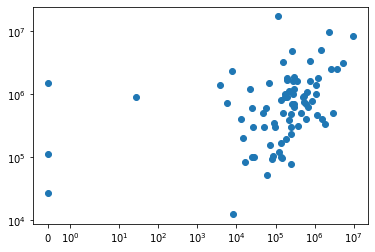

In [72]:
plt.scatter(bulkbasinweathering_OPTIMISED[0], WorldRivers_array)
plt.yscale('symlog')
plt.xscale('symlog')

In [73]:
#get linear correlation
x_value = bulkbasinweathering_FOAM[0]
y_value = WorldRivers_array
correlation_matrix = np.corrcoef(x_value, y_value)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(correlation_xy, r_squared)

0.3598468815317741 0.12948977814814264


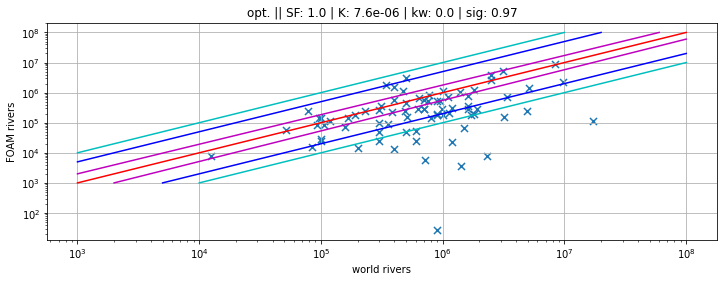

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))

ax.scatter(WorldRivers_array, bulkbasinweathering_OPTIMISED[0], marker='x', s=50)
#ax.plot(WorldRivers_array, y, c='orange')
ax.set_yscale('log')
ax.set_xscale('log')
#ax3.set_xlim(1e3,1e8)
#ax3.set_ylim(1e3,1e8)
ax.set_title('opt. || SF: %s | K: %s | kw: %s | sig: %s' % (np.round(res.x[3]*1000000,3),
                                                                f'{res.x[0]:.1e}',
                                                                np.round(res.x[1],3),
                                                                np.round(res.x[2]*1000,2)))
ax.set_xlabel('world rivers')
ax.set_ylabel('FOAM rivers')
ax.grid()

# plot equivalence line
ax.plot([1e3, 1e8],[1e3, 1e8],'r')
## plot 10 fold difference
ax.plot([1e4, 1e8],[1e3, 1e7], 'c')
ax.plot([1e3, 1e7],[1e4, 1e8], 'c')
### plot 5 fold difference
ax.plot([5e3, 1e8],[1e3, 2e7],'b')
ax.plot([1e3, 2e7],[5e3, 1e8],'b')
### plot 2 fold difference
ax.plot([2e3, 1e8],[1e3, 6e7],'m')
ax.plot([1e3, 6e7],[2e3, 1e8],'m')


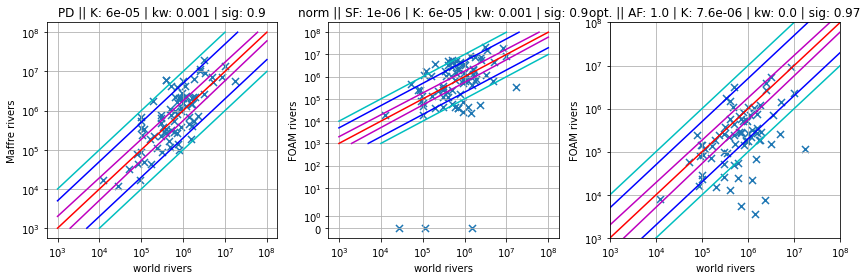

In [126]:
#world river comparisons
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

#world river comparisons
WorldRivers_file = './Maffre_equations/WorldRivers.mat'
WorldRivers = sp.loadmat(WorldRivers_file)
ax1.scatter(WorldRivers_array, bulkbasinweathering_PD, marker='x', s=50)
ax1.set_yscale('symlog')
ax1.set_xscale('symlog')
#ax1.set_xlim(1e3,1e8)
#ax1.set_ylim(1e3,1e8)
ax1.set_title('PD || K: %s | kw: %s | sig: %s' % (K, kw, sigplus1))
ax1.set_xlabel('world rivers')
ax1.set_ylabel('Maffre rivers')
ax1.grid()

# plot equivalence line
ax1.plot([1e3, 1e8],[1e3, 1e8],'r')
# plot 10 fold difference
ax1.plot([1e4, 1e8],[1e3, 1e7], 'c')
ax1.plot([1e3, 1e7],[1e4, 1e8], 'c')
## plot 5 fold difference
ax1.plot([5e3, 1e8],[1e3, 2e7],'b')
ax1.plot([1e3, 2e7],[5e3, 1e8],'b')
## plot 2 fold difference
ax1.plot([2e3, 1e8],[1e3, 6e7],'m')
ax1.plot([1e3, 6e7],[2e3, 1e8],'m')

ax2.scatter(WorldRivers_array, bulkbasinweathering_FOAM[0], marker='x', s=50)
ax2.set_yscale('symlog')
ax2.set_xscale('symlog')
#ax2.set_xlim(1e3,1e8)
#ax2.set_ylim(1e3,1e8)
ax2.set_title('norm || SF: %s | K: %s | kw: %s | sig: %s' % (default_variables[3],
                                                             default_variables[0],
                                                             default_variables[1],
                                                             default_variables[2]))
ax2.set_xlabel('world rivers')
ax2.set_ylabel('FOAM rivers')
ax2.grid()

# plot equivalence line
ax2.plot([1e3, 1e8],[1e3, 1e8],'r')
# plot 10 fold difference
ax2.plot([1e4, 1e8],[1e3, 1e7], 'c')
ax2.plot([1e3, 1e7],[1e4, 1e8], 'c')
## plot 5 fold difference
ax2.plot([5e3, 1e8],[1e3, 2e7],'b')
ax2.plot([1e3, 2e7],[5e3, 1e8],'b')
## plot 2 fold difference
ax2.plot([2e3, 1e8],[1e3, 6e7],'m')
ax2.plot([1e3, 6e7],[2e3, 1e8],'m')

ax3.scatter(WorldRivers['WorldRivers'] * 1e6, bulkbasinweathering_OPTIMISED[0], marker='x', s=50)
ax3.set_yscale('symlog')
ax3.set_xscale('symlog')
ax3.set_xlim(1e3,1e8)
ax3.set_ylim(1e3,1e8)
ax3.set_title('opt. || AF: %s | K: %s | kw: %s | sig: %s' % (np.round(res.x[3]*1000000,3),
                                                                f'{res.x[0]:.1e}',
                                                                np.round(res.x[1],3),
                                                                np.round(res.x[2]*1000,2)))

#In [31]: num = 0.09112346
#In [32]: f'{num:.5E}'
#Out[32]: '9.11235E-02'
    
    
ax3.set_xlabel('world rivers')
ax3.set_ylabel('FOAM rivers')
ax3.grid()

# plot equivalence line
ax3.plot([1e3, 1e8],[1e3, 1e8],'r')
# plot 10 fold difference
ax3.plot([1e4, 1e8],[1e3, 1e7], 'c')
ax3.plot([1e3, 1e7],[1e4, 1e8], 'c')
## plot 5 fold difference
ax3.plot([5e3, 1e8],[1e3, 2e7],'b')
ax3.plot([1e3, 2e7],[5e3, 1e8],'b')
## plot 2 fold difference
ax3.plot([2e3, 1e8],[1e3, 6e7],'m')
ax3.plot([1e3, 6e7],[2e3, 1e8],'m')

fig.tight_layout()

